# Stock Price BTC-USD with Stacked-Bidirectional LSTM-RNN
- Percobaan 1 = Vanilla LSTM-RNN
- Percobaan 2 = Stacked LSTM-RNN
- Percobaan 3 = Bidirectional LSTM-RNN
- Percobaan 4 = Stacked-Bidirectional LSTM-RNN

## 1. Deklarasi Pustaka

In [1]:
# pustaka untuk manipulasi data-frame
import pandas as pd
from pandas import concat
from pandas import read_csv
from pandas import read_excel
from pandas_datareader import DataReader

# pustaka untuk madnipulasi data-array
import numpy as np
from numpy import concatenate
from numpy import array

# pustaka untuk waktu komputasi
import time
from datetime import datetime

# pustaka untuk visualisasi data
import seaborn as sns
from matplotlib import pyplot
from matplotlib import pyplot as plt

# pustaka untuk visualisasi acf dan pacf
import scipy.stats as sc
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
        
# pustaka untuk membuat data latih dan data uji.
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

# pustaka untuk membuat model prediksi LSTM-RNN
import itertools
import tensorflow as tf
from keras.utils import Sequence
from keras.models import Sequential
from keras.layers import SimpleRNN
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import BatchNormalization
from keras.optimizers import Adam, Adamax, RMSprop, SGD

# early stoping
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

# pustaka untuk  evaluasi model prediksi
import math
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

## 2. Akuisisi Data

In [2]:
# Set waktu komputasi
start = time.time()

In [3]:
# fix random seed for reproducibility
np.random.seed(1234)

In [4]:
# membaca dataset via csv file
dataset = read_csv("dataset/BTC-USD.csv", parse_dates=['Date']);

In [5]:
# set index tanggal
dataset = dataset.set_index("Date");

In [6]:
# menampilkan metadata dataset
dataset.info();

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2896 entries, 2014-12-09 to 2022-11-12
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2896 non-null   float64
 1   High       2896 non-null   float64
 2   Low        2896 non-null   float64
 3   Close      2896 non-null   float64
 4   Adj Close  2896 non-null   float64
 5   Volume     2896 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 158.4 KB


In [7]:
dataset

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-12-09,361.894989,363.066986,344.950989,352.218994,352.218994,32915500
2014-12-10,352.204987,352.384003,346.364990,346.364990,346.364990,16427700
2014-12-11,344.339996,361.356995,338.763000,350.506012,350.506012,32431300
2014-12-12,350.833008,352.983002,349.290985,352.541992,352.541992,16989800
2014-12-13,352.381012,352.381012,346.588013,347.376007,347.376007,11675900
...,...,...,...,...,...,...
2022-11-08,20600.671875,20664.607422,17603.544922,18541.271484,18541.271484,118992465607
2022-11-09,18543.761719,18590.458984,15682.692383,15880.780273,15880.780273,102905151606
2022-11-10,15883.158203,18054.312500,15834.018555,17586.771484,17586.771484,83202283721


## 3. Eksplorasi Data Analisis

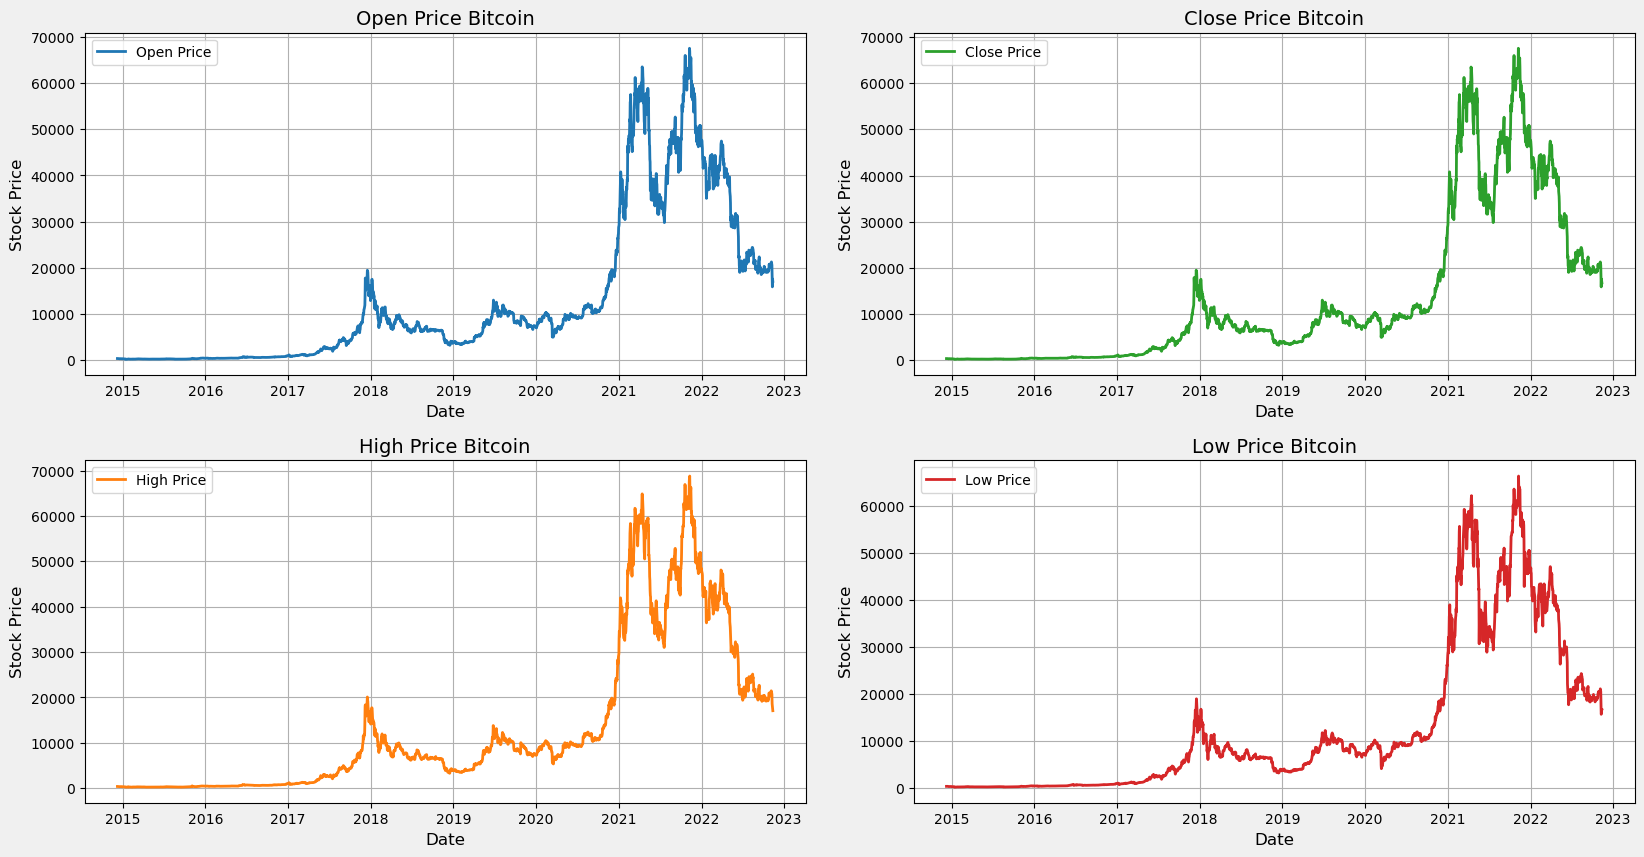

In [8]:
# membuat frame
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, facecolor="#f0f0f0", figsize=(20, 10))

# membuat time series plot
ax1.plot(dataset.index.values, dataset["Open"], color="tab:blue", label="Open Price", linewidth=2)

# membuat label-label
ax1.set_title("Open Price Bitcoin", fontsize=14)
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Stock Price", fontsize=12)
ax1.legend(loc='upper left')
ax1.grid(True)
# ----------------------------------------------------------------------------------------------------

# membuat time series plot
ax2.plot(dataset.index.values, dataset["Close"], color="tab:green", label="Close Price", linewidth=2)

# membuat label-label
ax2.set_title("Close Price Bitcoin", fontsize=14)
ax2.set_xlabel("Date", fontsize=12)
ax2.set_ylabel("Stock Price", fontsize=12)
ax2.legend(loc='upper left')
ax2.grid(True)
# ----------------------------------------------------------------------------------------------------

# membuat time series plot
ax3.plot(dataset.index.values, dataset["High"], color="tab:orange", label="High Price", linewidth=2)

# membuat label-label
ax3.set_title("High Price Bitcoin", fontsize=14)
ax3.set_xlabel("Date", fontsize=12)
ax3.set_ylabel("Stock Price", fontsize=12)
ax3.legend(loc='upper left')
ax3.grid(True)
# ----------------------------------------------------------------------------------------------------

# membuat time series plot
ax4.plot(dataset.index.values, dataset["Low"], color="tab:red", label="Low Price", linewidth=2)

# membuat label-label
ax4.set_title("Low Price Bitcoin", fontsize=14)
ax4.set_xlabel("Date", fontsize=12)
ax4.set_ylabel("Stock Price", fontsize=12)
ax4.legend(loc='upper left')
ax4.grid(True)
# ----------------------------------------------------------------------------------------------------

# set the spacing between subplots
plt.subplots_adjust(wspace=0.15, hspace=0.25)

# menampilkan plot
plt.show()

## 4. Praproses Dataset

- Seleksi Fitur

In [9]:
# memilih fitur close price
dataset = dataset.filter(['Close']);

In [10]:
# convert dataframe to series close price
data = dataset.values

In [11]:
np.round(data[:5],7)

array([[352.218994],
       [346.36499 ],
       [350.506012],
       [352.541992],
       [347.376007]])

In [12]:
data.shape

(2896, 1)

- Normalisasi Data

In [13]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(np.array(data).reshape(-1,1))

In [14]:
np.round(scaled_data[:5],7)

array([[0.0025838],
       [0.0024969],
       [0.0025583],
       [0.0025885],
       [0.0025119]])

In [15]:
scaled_data.shape

(2896, 1)

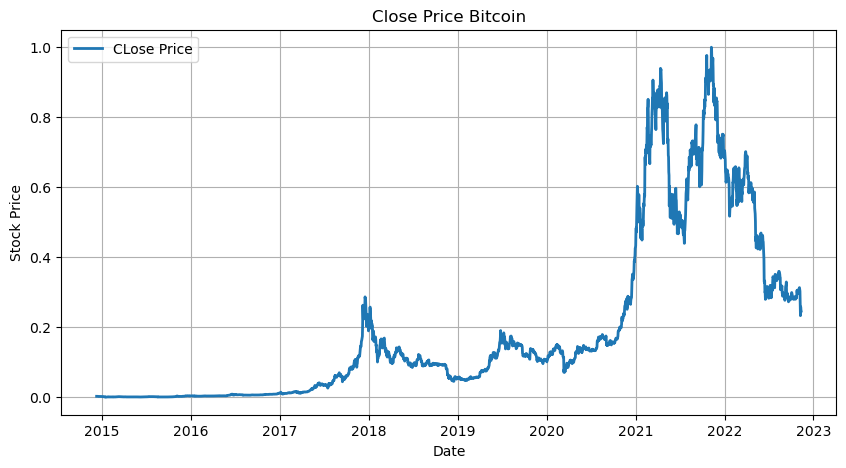

In [16]:
# membuat frame
fig, ax = plt.subplots(figsize = (10,5))

# membuat time series plot
ax.plot(dataset.index.values, scaled_data, color="tab:blue", label="CLose Price", linewidth=2)

# membuat label-label
ax.set_title("Close Price Bitcoin", fontsize=12)
ax.set_xlabel("Date", fontsize=10)
ax.set_ylabel("Stock Price", fontsize=10)
ax.legend(loc='upper left')
ax.grid(True)

# menampilkan plot
plt.show()

- split dataset

In [17]:
# split data train and test
train_data, test_data = train_test_split(scaled_data, train_size=0.80, test_size=0.20, shuffle=False)

In [18]:
# data train
np.round(train_data[:5],7)

array([[0.0025838],
       [0.0024969],
       [0.0025583],
       [0.0025885],
       [0.0025119]])

In [19]:
train_data.shape

(2316, 1)

In [20]:
# data test
np.round(test_data[:5],7)

array([[0.8861327],
       [0.9397025],
       [0.9338594],
       [0.9368913],
       [0.9110528]])

In [21]:
test_data.shape

(580, 1)

- Supervised Learning

In [22]:
# convert an array of values into a dataset matrix

# function for supervised learning
def create_dataset(look_back, dataset):
    
    # declare variable X and Y
    dataX = []
    dataY = []
    
    # for loop for create supervised learning
    for i in range(look_back, len(dataset)):
        
        # insert value X and Y 
        dataX.append(dataset[i-look_back:i, 0])
        dataY.append(dataset[i, 0])
        
    # return value X and Y
    return np.array(dataX), np.array(dataY)

In [23]:
# process supervised learning
look_back = 60
x_train, y_train = create_dataset(look_back, train_data)
x_test, y_test = create_dataset(look_back, test_data)

In [24]:
print(x_train.shape, y_train.shape)

(2256, 60) (2256,)


In [25]:
print(x_test.shape, y_test.shape)

(520, 60) (520,)


In [26]:
# reshape input to be [samples, time steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [27]:
print(x_train.shape, x_test.shape)

(2256, 60, 1) (520, 60, 1)


## 5. Building LSTM-RNN Models

### Percobaan 1 - Vanilla LSTM-RNN

In [28]:
# fix random seed for reproducibility
np.random.seed(1234)

In [29]:
# The LSTM architecture
model_1 = tf.keras.Sequential([
    
    # The input layer
    tf.keras.layers.LSTM(units=50, input_shape=(x_train.shape[1], 1)),
    
    # The output layer
    tf.keras.layers.Dense(1)
])

In [30]:
# Compile the model LSTM
model_1.compile(optimizer='adam', loss='mean_squared_error')

In [31]:
# fit network
history_1 = model_1.fit(x_train, y_train, epochs=50, batch_size=8, verbose=1, use_multiprocessing=True, shuffle=False)

Epoch 1/50
282/282 [==============================] - 4s 10ms/step - loss: 5.3764e-04
Epoch 2/50
282/282 [==============================] - 3s 10ms/step - loss: 0.0013
Epoch 3/50
282/282 [==============================] - 3s 10ms/step - loss: 0.0011
Epoch 4/50
282/282 [==============================] - 3s 11ms/step - loss: 7.7693e-04
Epoch 5/50
282/282 [==============================] - 3s 10ms/step - loss: 5.9156e-04
Epoch 6/50
282/282 [==============================] - 3s 10ms/step - loss: 4.2993e-04
Epoch 7/50
282/282 [==============================] - 3s 10ms/step - loss: 2.9175e-04
Epoch 8/50
282/282 [==============================] - 3s 10ms/step - loss: 2.0122e-04
Epoch 9/50
282/282 [==============================] - 3s 10ms/step - loss: 1.4882e-04
Epoch 10/50
282/282 [==============================] - 3s 11ms/step - loss: 1.3007e-04
Epoch 11/50
282/282 [==============================] - 3s 10ms/step - loss: 1.2400e-04
Epoch 12/50
282/282 [==============================] - 3s 10

In [32]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [33]:
testPredictions_1 = model_1.predict(x_test)
print(testPredictions_1[:7])

17/17 [==============================] - 1s 6ms/step
[[0.5499227 ]
 [0.5574976 ]
 [0.53189576]
 [0.58172566]
 [0.5993994 ]
 [0.6016701 ]
 [0.57170594]]


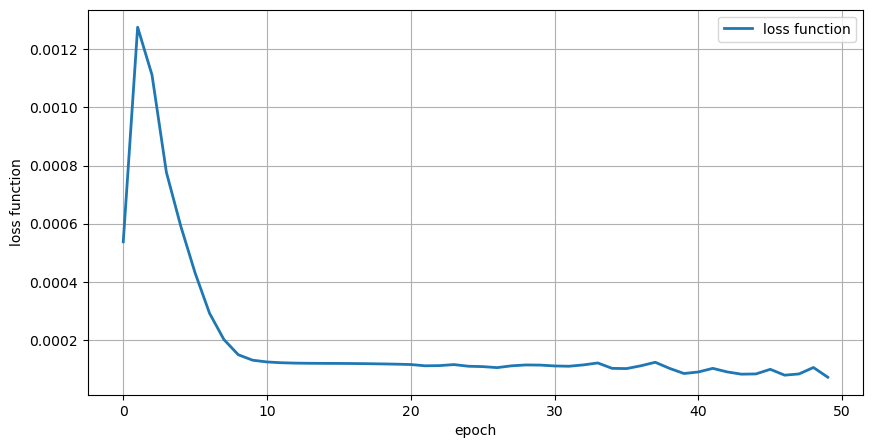

In [34]:
# membuat frame
fig, ax = plt.subplots(figsize = (10,5))

# membuat time series plot
ax.plot(history_1.history['loss'], color="tab:blue", label="loss function", linewidth=2)

# membuat label-label
ax.set_xlabel("epoch", fontsize=10)
ax.set_ylabel("loss function", fontsize=10)
ax.legend(loc='upper right')
ax.grid(True)

# menampilkan plot
plt.show()

#### Evaluasi Model - Percobaan 1 Vanilla LSTM-RNN

In [35]:
scores_1 = model_1.evaluate(x_train, y_train)
scores_1

71/71 [==============================] - 1s 6ms/step - loss: 1.0916e-04


0.00010915903112618253

In [36]:
scores_1 = model_1.evaluate(x_test, y_test)
scores_1

17/17 [==============================] - 0s 6ms/step - loss: 4.4193e-04


0.0004419322940520942

- MAE (Mean Absolute Error)

In [37]:
mae_1 = mean_absolute_error(y_test, testPredictions_1)
print('Test MAE : %.4f' % mae_1)

Test MAE : 0.0154


- MSE (Mean Squared Error)

In [38]:
mse_1 = mean_squared_error(y_test, testPredictions_1)
print('Test MSE: %.4f' % mse_1)

Test MSE: 0.0004


- RMSE (Root Mean Squared Error)

In [39]:
rmse_1 = sqrt(mse_1)
print('Test RMSE: %.4f' % rmse_1)

Test RMSE: 0.0210


- Corelation pearson

In [40]:
hasil_1 = np.stack((y_test.reshape(-1), testPredictions_1.reshape(-1)), axis=1)
hasil_1 = pd.DataFrame(hasil_1, columns = ['data_aktual','prediksi'])

In [41]:
hasil_1

,data_aktual,prediksi
0,0.551373,0.549923
1,0.524931,0.557498
2,0.577541,0.531896
3,0.594170,0.581726
4,0.596957,0.599399
...,...,...
515,0.272496,0.310015
516,0.233016,0.282261
517,0.258332,0.244363
518,0.250134,0.262923


In [42]:
r1, p1 = sc.pearsonr(hasil_1["data_aktual"], hasil_1["prediksi"])
print("korelasi data akual dengan hasil prediksi" +" {:.4f} ".format(r1)+ "dengan signifikansi" +" {:.4f} ".format(p1))

korelasi data akual dengan hasil prediksi 0.9946 dengan signifikansi 0.0000 


#### Visualisasi Data - Percobaan 1 Vanilla LSTM-RNN

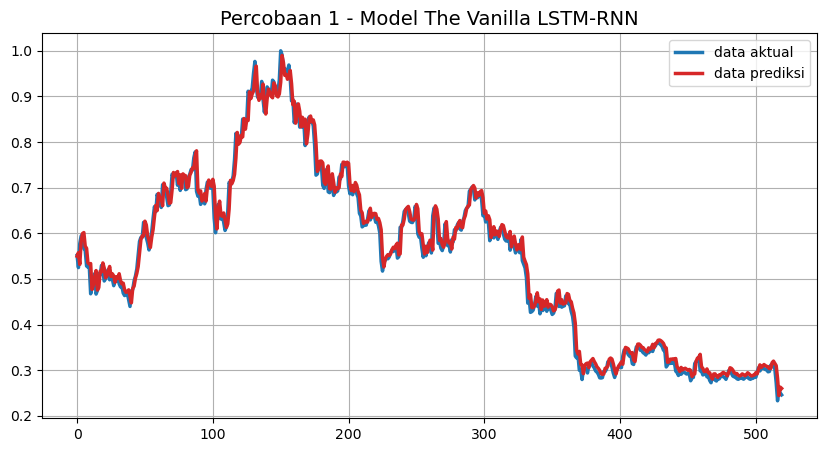

In [43]:
# membuat frame
fig, ax = plt.subplots(figsize = (10,5))

# membuat time series plot
ax.plot(y_test, color="tab:blue", label="data aktual", linewidth=2.5)
ax.plot(testPredictions_1, color="tab:red", label="data prediksi", linewidth=2.5)

# membuat label-label
ax.set_title("Percobaan 1 - Model The Vanilla LSTM-RNN", fontsize=14)
ax.legend(loc="best")
ax.grid(True)

# menampilka
plt.show()

In [44]:
# inverse value test predictions
testPredictions_1 = scaler.inverse_transform(testPredictions_1)

In [45]:
# shift test predictions for plotting
testPredictionsPlot_1 = np.empty_like(scaled_data)
testPredictionsPlot_1[:, :] = np.nan
testPredictionsPlot_1[(len(dataset) - testPredictions_1.shape[0]):len(dataset), :] = testPredictions_1

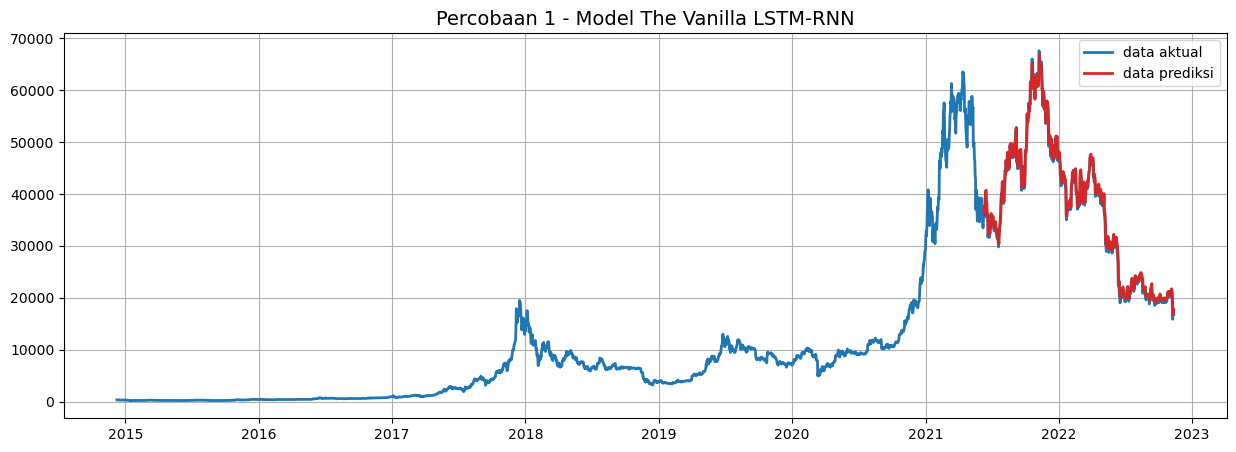

In [46]:
# membuat frame
fig, ax = plt.subplots(figsize = (15,5))

# membuat time series plot
ax.plot(dataset.index.values, scaler.inverse_transform(scaled_data), color="tab:blue", label="data aktual", linewidth=2)
ax.plot(dataset.index.values, testPredictionsPlot_1, color="tab:red", label="data prediksi", linewidth=2)

# membuat label-label
ax.set_title("Percobaan 1 - Model The Vanilla LSTM-RNN", fontsize=14)
ax.legend(loc="best")
ax.grid(True)

# menampilka
plt.show()

### Percobaan 2 - Stacked LSTM-RNN 

In [47]:
# fix random seed for reproducibility
np.random.seed(1234)

In [48]:
# The LSTM architecture
model_2 = tf.keras.Sequential([
    
    # First LSTM layer with Dropout regularisation
    tf.keras.layers.LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    
    # Second LSTM layer with Dropout regularisation
    tf.keras.layers.LSTM(units=50, return_sequences=False),
    
    # The output layer
    tf.keras.layers.Dense(1)
])

In [49]:
# Compile the model LSTM
model_2.compile(optimizer='adam', loss='mean_squared_error')

In [50]:
# fit network
history_2 = model_2.fit(x_train, y_train, epochs=50, batch_size=8, verbose=1, use_multiprocessing=True, shuffle=False)

Epoch 1/50
282/282 [==============================] - 8s 20ms/step - loss: 0.0014
Epoch 2/50
282/282 [==============================] - 5s 19ms/step - loss: 0.0035
Epoch 3/50
282/282 [==============================] - 5s 19ms/step - loss: 0.0047
Epoch 4/50
282/282 [==============================] - 6s 20ms/step - loss: 0.0033
Epoch 5/50
282/282 [==============================] - 5s 19ms/step - loss: 0.0013
Epoch 6/50
282/282 [==============================] - 6s 20ms/step - loss: 0.0014
Epoch 7/50
282/282 [==============================] - 6s 20ms/step - loss: 8.8495e-04
Epoch 8/50
282/282 [==============================] - 5s 19ms/step - loss: 4.1962e-04
Epoch 9/50
282/282 [==============================] - 6s 20ms/step - loss: 2.8873e-04
Epoch 10/50
282/282 [==============================] - 6s 20ms/step - loss: 2.2601e-04
Epoch 11/50
282/282 [==============================] - 5s 19ms/step - loss: 1.9622e-04
Epoch 12/50
282/282 [==============================] - 6s 20ms/step - loss: 

In [51]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 60, 50)            10400     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [52]:
testPredictions_2 = model_2.predict(x_test)
print(testPredictions_2[:7])

17/17 [==============================] - 1s 10ms/step
[[0.522154  ]
 [0.53010654]
 [0.5003928 ]
 [0.552233  ]
 [0.5672159 ]
 [0.56903726]
 [0.5351485 ]]


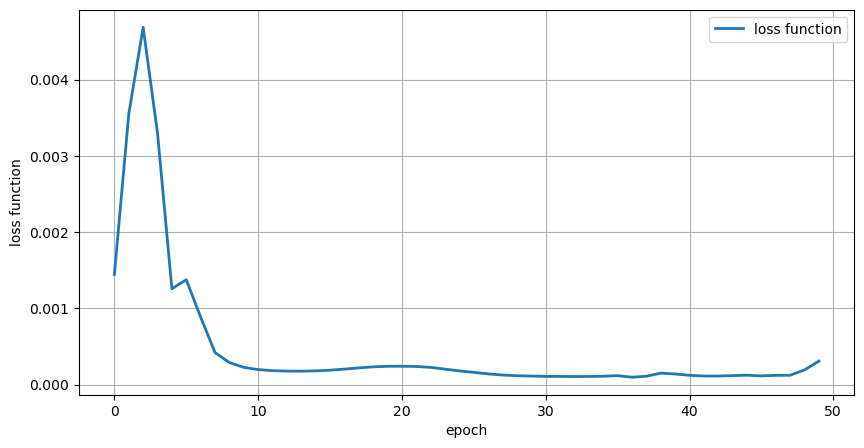

In [53]:
# membuat frame
fig, ax = plt.subplots(figsize = (10,5))

# membuat time series plot
ax.plot(history_2.history['loss'], color="tab:blue", label="loss function", linewidth=2)

# membuat label-label
ax.set_xlabel("epoch", fontsize=10)
ax.set_ylabel("loss function", fontsize=10)
ax.legend(loc='upper right')
ax.grid(True)

# menampilkan plot
plt.show()

#### Evaluasi Model - Percobaan 2 Stacked LSTM-RNN

In [54]:
scores_2 = model_1.evaluate(x_train, y_train)
scores_2

71/71 [==============================] - 0s 6ms/step - loss: 1.0916e-04


0.00010915903112618253

In [55]:
scores_2 = model_1.evaluate(x_test, y_test)
scores_2

17/17 [==============================] - 0s 6ms/step - loss: 4.4193e-04


0.0004419322940520942

- MAE (Mean Absolute Error)

In [56]:
mae_2 = mean_absolute_error(y_test, testPredictions_2)
print('Test MAE : %.4f' % mae_2)

Test MAE : 0.0234


- MSE (Mean Squared Error)

In [57]:
mse_2 = mean_squared_error(y_test, testPredictions_2)
print('Test MSE: %.4f' % mse_2)

Test MSE: 0.0009


- RMSE (Root Mean Squared Error)

In [58]:
rmse_2 = sqrt(mse_2)
print('Test RMSE: %.4f' % rmse_2)

Test RMSE: 0.0292


- Corelation pearson

In [59]:
hasil_2 = np.stack((y_test.reshape(-1), testPredictions_2.reshape(-1)), axis=1)
hasil_2 = pd.DataFrame(hasil_2, columns = ['data_aktual','prediksi'])

In [60]:
hasil_2

,data_aktual,prediksi
0,0.551373,0.522154
1,0.524931,0.530107
2,0.577541,0.500393
3,0.594170,0.552233
4,0.596957,0.567216
...,...,...
515,0.272496,0.288252
516,0.233016,0.260929
517,0.258332,0.226336
518,0.250134,0.248133


In [61]:
r2, p2 = sc.pearsonr(hasil_2["data_aktual"], hasil_2["prediksi"])
print("korelasi data akual dengan hasil prediksi" +" {:.4f} ".format(r2)+ "dengan signifikansi" +" {:.4f} ".format(p2))

korelasi data akual dengan hasil prediksi 0.9923 dengan signifikansi 0.0000 


#### Visualisasi Data - Percobaan 2 Stacked LSTM-RNN

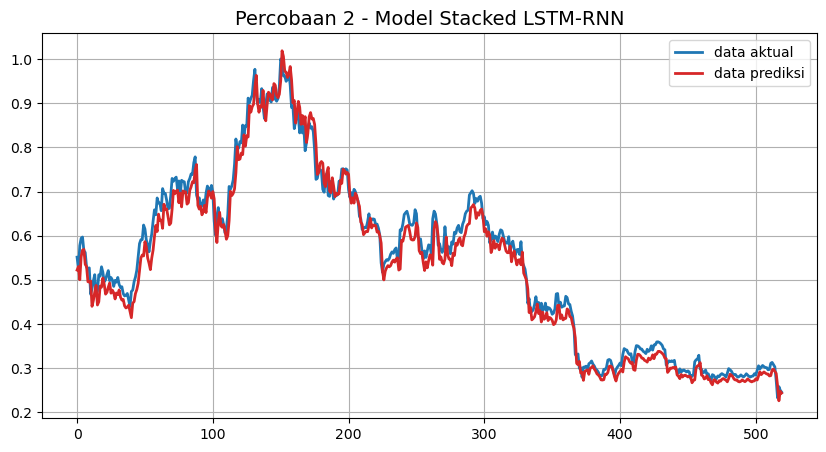

In [62]:
# membuat frame
fig, ax = plt.subplots(figsize = (10,5))

# membuat time series plot
ax.plot(y_test, color="tab:blue", label="data aktual", linewidth=2)
ax.plot(testPredictions_2, color="tab:red", label="data prediksi", linewidth=2)

# membuat label-label
ax.set_title("Percobaan 2 - Model Stacked LSTM-RNN", fontsize=14)
ax.legend(loc="best")
ax.grid(True)

# menampilka
plt.show()

In [63]:
# inverse value test predictions
testPredictions_2 = scaler.inverse_transform(testPredictions_2)

In [64]:
# shift test predictions for plotting
testPredictionsPlot_2 = np.empty_like(scaled_data)
testPredictionsPlot_2[:, :] = np.nan
testPredictionsPlot_2[(len(dataset) - testPredictions_2.shape[0]):len(dataset), :] = testPredictions_2

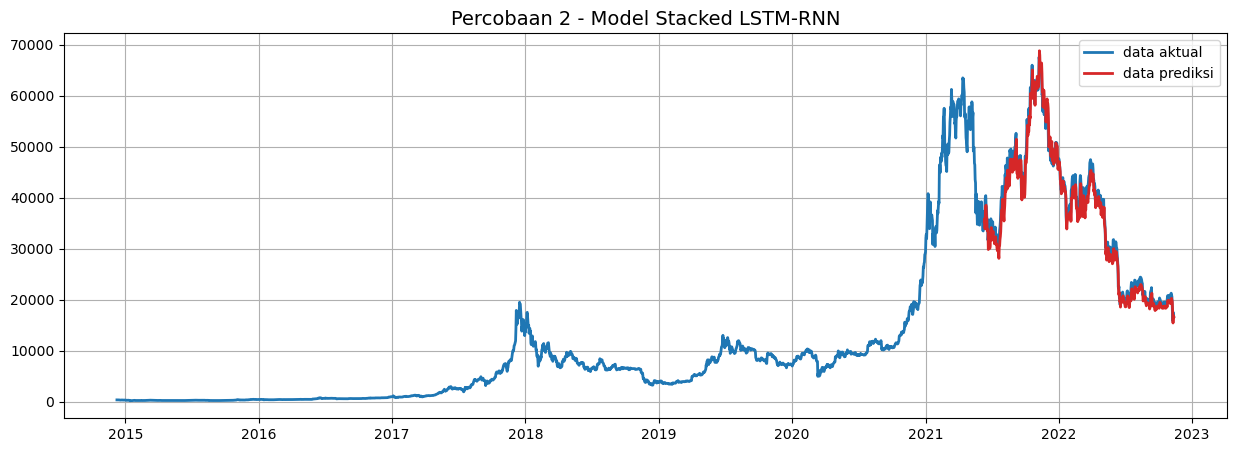

In [65]:
# membuat frame
fig, ax = plt.subplots(figsize = (15,5))

# membuat time series plot
ax.plot(dataset.index.values, scaler.inverse_transform(scaled_data), color="tab:blue", label="data aktual", linewidth=2)
ax.plot(dataset.index.values, testPredictionsPlot_2, color="tab:red", label="data prediksi", linewidth=2)

# membuat label-label
ax.set_title("Percobaan 2 - Model Stacked LSTM-RNN", fontsize=14)
ax.legend(loc="best")
ax.grid(True)

# menampilka
plt.show()

### Percobaan 3 - Bidirectional LSTM-RNN

In [66]:
# fix random seed for reproducibility
np.random.seed(1234)

In [67]:
# The LSTM architecture
model_3 = tf.keras.Sequential([
    
    # The input layer
    tf.keras.layers.Bidirectional(
        LSTM(units=50, input_shape=(x_train.shape[1], 1))
    ),
    
    # The output layer
    tf.keras.layers.Dense(1)
])

In [68]:
# Compile the model GRU
model_3.compile(optimizer='adam', loss='mean_squared_error')

In [69]:
# fit network
history_3 = model_3.fit(x_train, y_train, epochs=50, batch_size=8, verbose=1, use_multiprocessing=True, shuffle=False)

Epoch 1/50
282/282 [==============================] - 6s 10ms/step - loss: 8.8710e-04
Epoch 2/50
282/282 [==============================] - 3s 10ms/step - loss: 0.0036
Epoch 3/50
282/282 [==============================] - 3s 11ms/step - loss: 0.0026
Epoch 4/50
282/282 [==============================] - 3s 11ms/step - loss: 0.0017
Epoch 5/50
282/282 [==============================] - 3s 10ms/step - loss: 0.0011
Epoch 6/50
282/282 [==============================] - 3s 10ms/step - loss: 4.5271e-04
Epoch 7/50
282/282 [==============================] - 3s 11ms/step - loss: 2.2985e-04
Epoch 8/50
282/282 [==============================] - 3s 10ms/step - loss: 2.0521e-04
Epoch 9/50
282/282 [==============================] - 3s 10ms/step - loss: 2.0093e-04
Epoch 10/50
282/282 [==============================] - 3s 10ms/step - loss: 1.9914e-04
Epoch 11/50
282/282 [==============================] - 3s 10ms/step - loss: 1.9702e-04
Epoch 12/50
282/282 [==============================] - 3s 10ms/step 

In [70]:
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (8, 100)                 20800     
 l)                                                              
                                                                 
 dense_2 (Dense)             (8, 1)                    101       
                                                                 
Total params: 20,901
Trainable params: 20,901
Non-trainable params: 0
_________________________________________________________________


In [71]:
testPredictions_3 = model_3.predict(x_test)
print(testPredictions_3[:7])

17/17 [==============================] - 1s 6ms/step
[[0.59260964]
 [0.6016137 ]
 [0.5762631 ]
 [0.62484956]
 [0.6429671 ]
 [0.64367354]
 [0.6105424 ]]


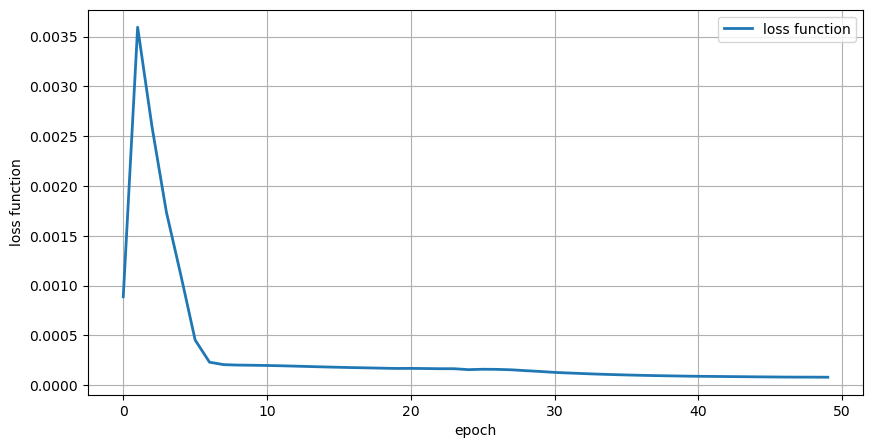

In [72]:
# membuat frame
fig, ax = plt.subplots(figsize = (10,5))

# membuat time series plot
ax.plot(history_3.history['loss'], color="tab:blue", label="loss function", linewidth=2)

# membuat label-label
ax.set_xlabel("epoch", fontsize=10)
ax.set_ylabel("loss function", fontsize=10)
ax.legend(loc='upper right')
ax.grid(True)

# menampilkan plot
plt.show()

#### Evaluasi Model - Percobaan 3 Bidirectional LSTM-RNN

In [73]:
scores_3 = model_3.evaluate(x_train, y_train)
scores_3

71/71 [==============================] - 1s 6ms/step - loss: 3.0756e-04


0.0003075560962315649

In [74]:
scores_3 = model_3.evaluate(x_test, y_test)
scores_3

17/17 [==============================] - 0s 6ms/step - loss: 0.0013


0.0012723436811938882

- MAE (Mean Absolute Error)

In [75]:
mae_3 = mean_absolute_error(y_test, testPredictions_3)
print('Test MAE : %.4f' % mae_3)

Test MAE : 0.0306


- MSE (Mean Squared Error)

In [76]:
mse_3 = mean_squared_error(y_test, testPredictions_3)
print('Test MSE: %.4f' % mse_3)

Test MSE: 0.0013


- RMSE (Root Mean Squared Error)

In [77]:
rmse_3 = sqrt(mse_3)
print('Test RMSE: %.4f' % rmse_3)

Test RMSE: 0.0357


- Corelation pearson

In [78]:
hasil_3 = np.stack((y_test.reshape(-1), testPredictions_3.reshape(-1)), axis=1)
hasil_3 = pd.DataFrame(hasil_3, columns = ['data_aktual','prediksi'])

In [79]:
hasil_3

,data_aktual,prediksi
0,0.551373,0.592610
1,0.524931,0.601614
2,0.577541,0.576263
3,0.594170,0.624850
4,0.596957,0.642967
...,...,...
515,0.272496,0.324295
516,0.233016,0.297268
517,0.258332,0.260220
518,0.250134,0.278015


In [80]:
r3, p3 = sc.pearsonr(hasil_3["data_aktual"], hasil_3["prediksi"])
print("korelasi data akual dengan hasil prediksi" +" {:.4f} ".format(r3)+ "dengan signifikansi" +" {:.4f} ".format(p3))

korelasi data akual dengan hasil prediksi 0.9930 dengan signifikansi 0.0000 


#### Visualisasi Data - Percobaan 3 Bidirectional LSTM-RNN

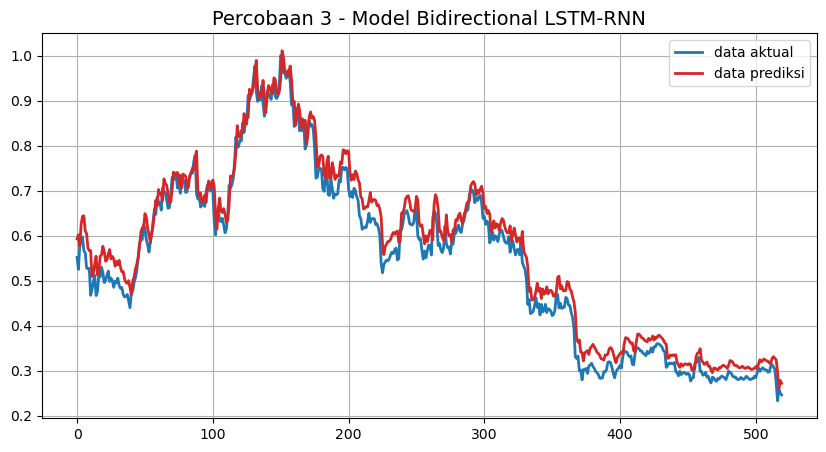

In [81]:
# membuat frame
fig, ax = plt.subplots(figsize = (10,5))

# membuat time series plot
ax.plot(y_test, color="tab:blue", label="data aktual", linewidth=2)
ax.plot(testPredictions_3, color="tab:red", label="data prediksi", linewidth=2)

# membuat label-label
ax.set_title("Percobaan 3 - Model Bidirectional LSTM-RNN", fontsize=14)
ax.legend(loc="best")
ax.grid(True)

# menampilka
plt.show()

In [82]:
# inverse value test predictions
testPredictions_3 = scaler.inverse_transform(testPredictions_3)

In [83]:
# shift test predictions for plotting
testPredictionsPlot_3 = np.empty_like(scaled_data)
testPredictionsPlot_3[:, :] = np.nan
testPredictionsPlot_3[(len(dataset) - testPredictions_3.shape[0]):len(dataset), :] = testPredictions_3

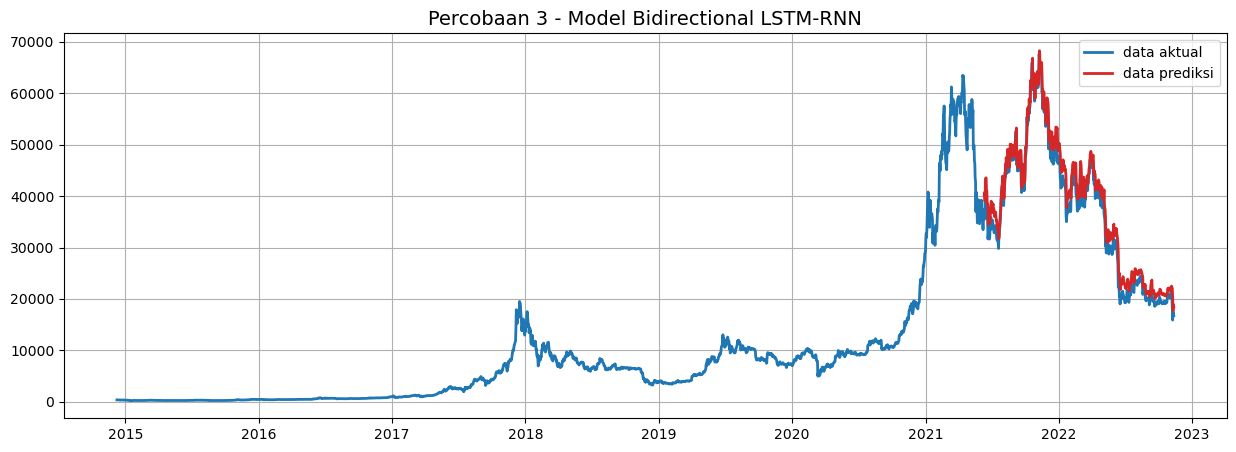

In [84]:
# membuat frame
fig, ax = plt.subplots(figsize = (15,5))

# membuat time series plot
ax.plot(dataset.index.values, scaler.inverse_transform(scaled_data), color="tab:blue", label="data aktual", linewidth=2)
ax.plot(dataset.index.values, testPredictionsPlot_3, color="tab:red", label="data prediksi", linewidth=2)

# membuat label-label
ax.set_title("Percobaan 3 - Model Bidirectional LSTM-RNN", fontsize=14)
ax.legend(loc="best")
ax.grid(True)

# menampilka
plt.show()

### Percobaan 4 - Stacked-Bidirectional LSTM-RNN

In [85]:
# fix random seed for reproducibility
np.random.seed(1234);

In [86]:
# The LSTM architecture
model_4 = Sequential()

# First LSTM layer with Dropout regularisation
model_4.add(
    Bidirectional(
        LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1))
    )
)

# Second LSTM layer with Dropout regularisation
model_4.add(
    Bidirectional(
        LSTM(units=50, return_sequences=True)
    )
)
model_4.add(
    Bidirectional(
        LSTM(units=50, return_sequences=False)
    )
)


# The output layer
model_4.add(Dense(1))

# Compile the model LSTM
model_4.compile(optimizer='adam', loss='mean_squared_error')

In [87]:
# fit network
history_4 = model_4.fit(x_train, y_train, epochs=50, batch_size=8, verbose=1, use_multiprocessing=True, shuffle=False)

Epoch 1/50
282/282 [==============================] - 17s 29ms/step - loss: 0.0023
Epoch 2/50
282/282 [==============================] - 8s 30ms/step - loss: 0.0049
Epoch 3/50
282/282 [==============================] - 9s 30ms/step - loss: 0.0077
Epoch 4/50
282/282 [==============================] - 9s 31ms/step - loss: 0.0029
Epoch 5/50
282/282 [==============================] - 8s 30ms/step - loss: 0.0012
Epoch 6/50
282/282 [==============================] - 9s 31ms/step - loss: 3.0887e-04
Epoch 7/50
282/282 [==============================] - 8s 29ms/step - loss: 2.3231e-04
Epoch 8/50
282/282 [==============================] - 8s 30ms/step - loss: 2.2217e-04
Epoch 9/50
282/282 [==============================] - 8s 29ms/step - loss: 2.4088e-04
Epoch 10/50
282/282 [==============================] - 8s 30ms/step - loss: 2.4938e-04
Epoch 11/50
282/282 [==============================] - 8s 30ms/step - loss: 2.5636e-04
Epoch 12/50
282/282 [==============================] - 9s 31ms/step - l

In [88]:
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirectio  (8, 60, 100)             20800     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (8, 60, 100)             60400     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (8, 100)                 60400     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (8, 1)                    101       
                                                                 
Total params: 141,701
Trainable params: 141,701
Non-trainable params: 0
________________________________________________

In [89]:
testPredictions_4 = model_4.predict(x_test)
print(testPredictions_4[:7])

17/17 [==============================] - 4s 18ms/step
[[0.50720394]
 [0.5148601 ]
 [0.48872128]
 [0.5366931 ]
 [0.55858684]
 [0.56126034]
 [0.52788   ]]


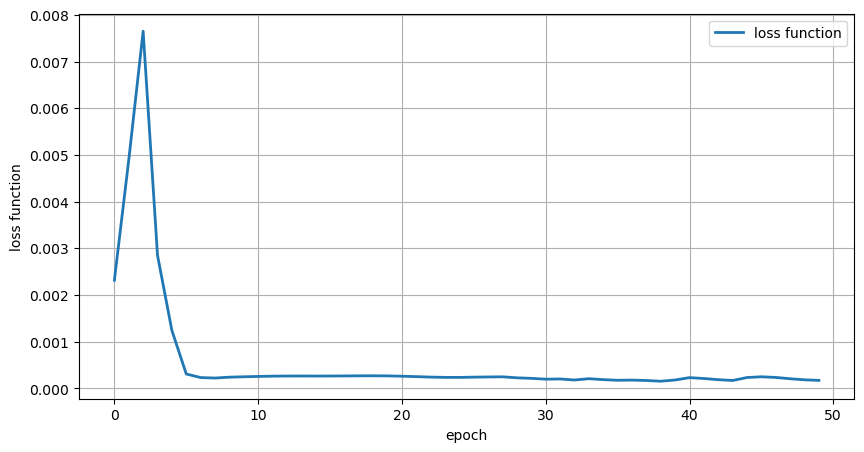

In [90]:
# membuat frame
fig, ax = plt.subplots(figsize = (10,5))

# membuat time series plot
ax.plot(history_4.history['loss'], color="tab:blue", label="loss function", linewidth=2)

# membuat label-label
ax.set_xlabel("epoch", fontsize=10)
ax.set_ylabel("loss function", fontsize=10)
ax.legend(loc='upper right')
ax.grid(True)

# menampilkan plot
plt.show()

#### Evaluasi Model - Percobaan 4 Stacked-Bidirectional LSTM-RNN

In [91]:
scores_4 = model_4.evaluate(x_train, y_train)
scores_4

71/71 [==============================] - 3s 18ms/step - loss: 8.7901e-04


0.0008790132706053555

In [92]:
scores_4 = model_4.evaluate(x_test, y_test)
scores_4

17/17 [==============================] - 0s 18ms/step - loss: 0.0025


0.0024536214768886566

- MAE (Mean Absolute Error)

In [93]:
mae_4 = mean_absolute_error(y_test, testPredictions_4)
print('Test MAE : %.4f' % mae_4)

Test MAE : 0.0444


- MSE (Mean Squared Error)

In [94]:
mse_4 = mean_squared_error(y_test, testPredictions_4)
print('Test MSE: %.4f' % mse_4)

Test MSE: 0.0025


- RMSE (Root Mean Squared Error)

In [95]:
rmse_4 = sqrt(mse_4)
print('Test RMSE: %.4f' % rmse_4)

Test RMSE: 0.0495


- Corelation pearson

In [96]:
hasil_4 = np.stack((y_test.reshape(-1), testPredictions_4.reshape(-1)), axis=1)
hasil_4 = pd.DataFrame(hasil_4, columns = ['data_aktual','prediksi'])

In [97]:
hasil_4

,data_aktual,prediksi
0,0.551373,0.507204
1,0.524931,0.514860
2,0.577541,0.488721
3,0.594170,0.536693
4,0.596957,0.558587
...,...,...
515,0.272496,0.242387
516,0.233016,0.219741
517,0.258332,0.189460
518,0.250134,0.202260


In [98]:
r4, p4 = sc.pearsonr(hasil_4["data_aktual"], hasil_4["prediksi"])
print("korelasi data akual dengan hasil prediksi" +" {:.4f} ".format(r4)+ "dengan signifikansi" +" {:.4f} ".format(p4))

korelasi data akual dengan hasil prediksi 0.9934 dengan signifikansi 0.0000 


#### Visualisasi Data - Percobaan 4 Stacked-Bidirectional LSTM-RNN

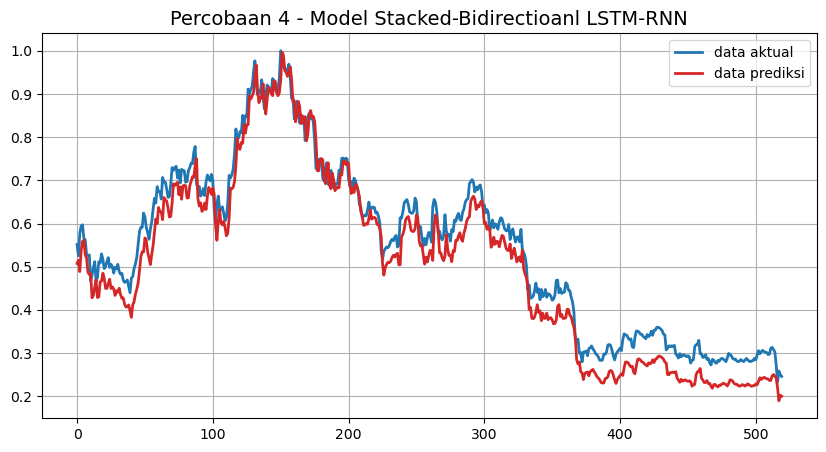

In [99]:
# membuat frame
fig, ax = plt.subplots(figsize = (10,5))

# membuat time series plot
ax.plot(y_test, color="tab:blue", label="data aktual", linewidth=2)
ax.plot(testPredictions_4, color="tab:red", label="data prediksi", linewidth=2)

# membuat label-label
ax.set_title("Percobaan 4 - Model Stacked-Bidirectioanl LSTM-RNN", fontsize=14)
ax.legend(loc="best")
ax.grid(True)

# menampilka
plt.show()

In [100]:
# inverse value test predictions
testPredictions_4 = scaler.inverse_transform(testPredictions_4)

In [101]:
# shift test predictions for plotting
testPredictionsPlot_4 = np.empty_like(scaled_data)
testPredictionsPlot_4[:, :] = np.nan
testPredictionsPlot_4[(len(dataset) - testPredictions_4.shape[0]):len(dataset), :] = testPredictions_4

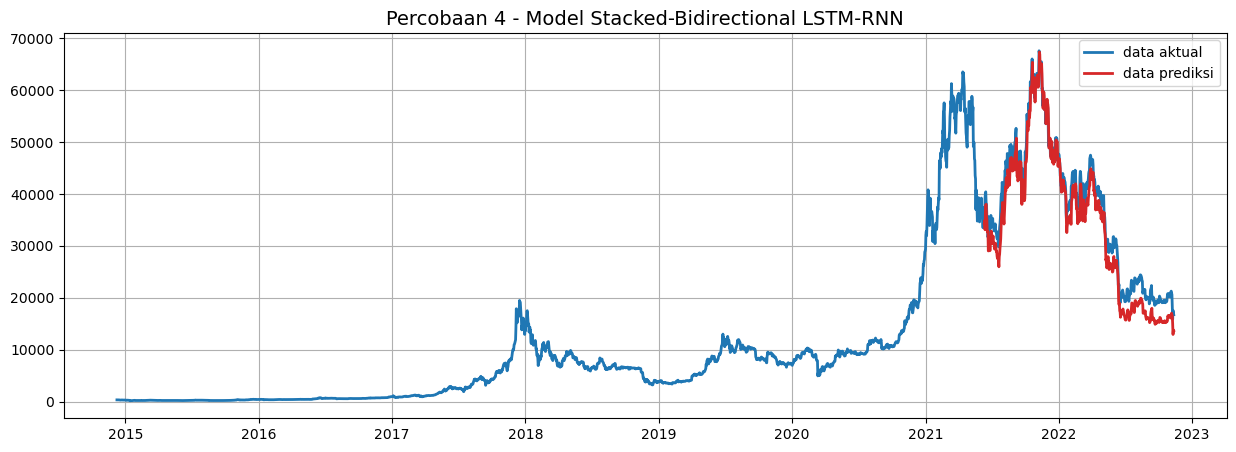

In [102]:
# membuat frame
fig, ax = plt.subplots(figsize = (15,5))

# membuat time series plot
ax.plot(dataset.index.values, scaler.inverse_transform(scaled_data), color="tab:blue", label="data aktual", linewidth=2)
ax.plot(dataset.index.values, testPredictionsPlot_4, color="tab:red", label="data prediksi", linewidth=2)

# membuat label-label
ax.set_title("Percobaan 4 - Model Stacked-Bidirectional LSTM-RNN", fontsize=14)
ax.legend(loc="best")
ax.grid(True)

# menampilkan plot
plt.show()

## 6. Evaluasi Model Vanilla, Stacked, Bidirectional LSTM-RNN

In [103]:
hasil = pd.DataFrame({
    'MAE' : [mae_1, mae_2, mae_3, mae_4],
    'MSE' : [mse_1, mse_2, mse_3, mse_4],
    'RMSE' : [rmse_1, rmse_2, rmse_3, rmse_4],
    'R' : [r1, r2, r3, r4],
    'R2' : [p1, p2, p3, p4],
}, index=['Percobaan 1','Percobaan 2','Percobaan 3','Percobaan 4'])

In [104]:
hasil

,MAE,MSE,RMSE,R,R2
Percobaan 1,0.015367,0.000442,0.021022,0.994619,0.0
Percobaan 2,0.023447,0.000854,0.029219,0.992312,0.0
Percobaan 3,0.030558,0.001272,0.035670,0.993016,0.0
Percobaan 4,0.044439,0.002454,0.049534,0.993381,0.0


## 7. Visualisasi Data Vanilla, Stacked, Bidirectional LSTM-RNN

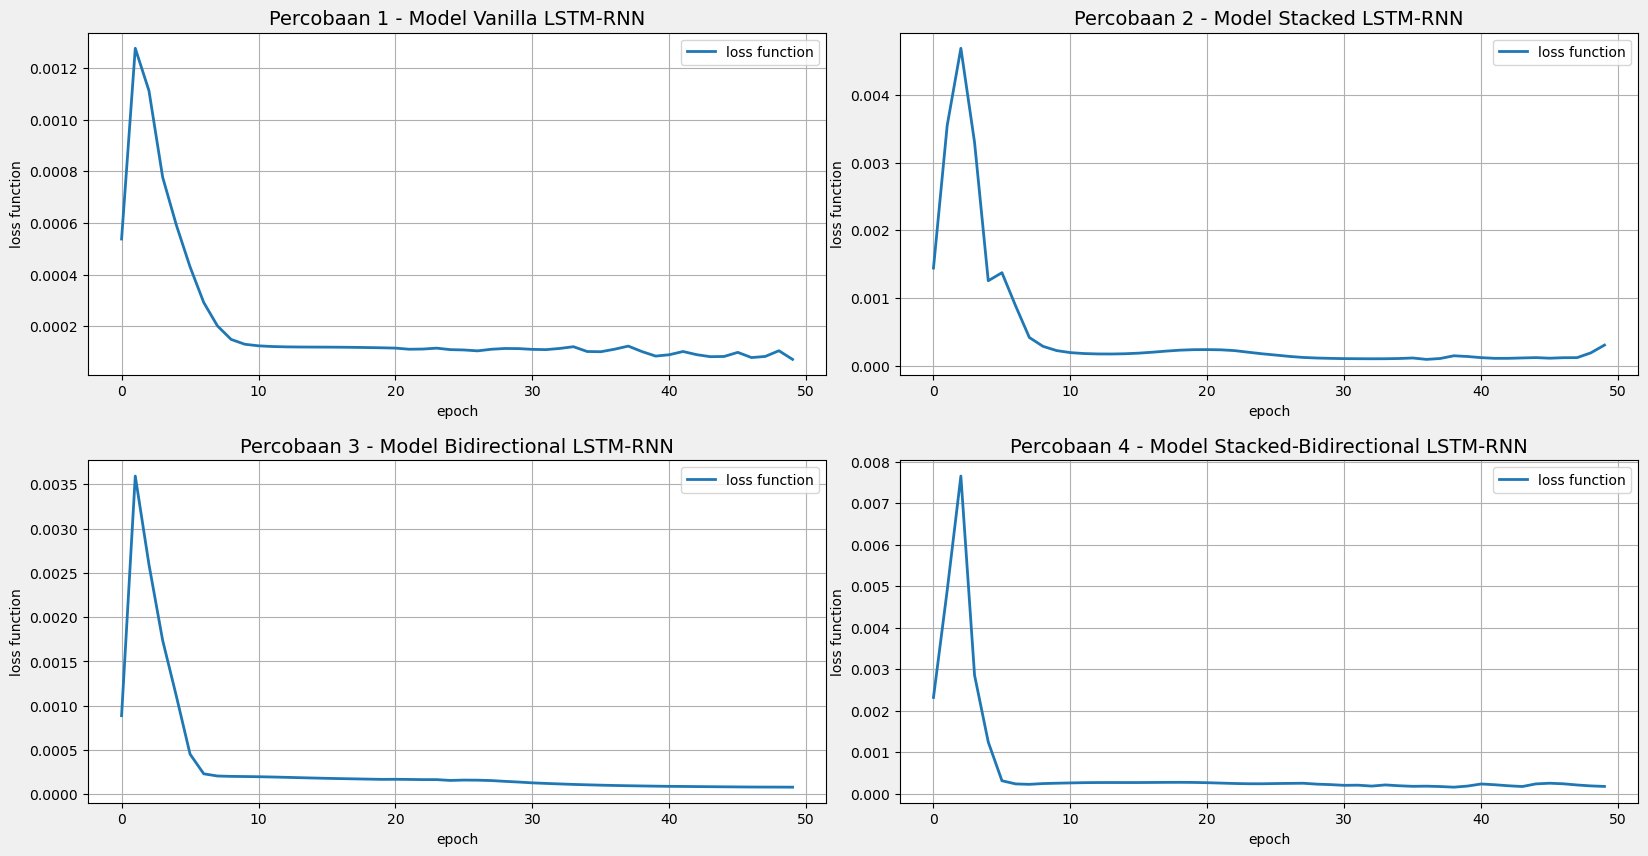

In [105]:
# membuat frame
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, facecolor="#f0f0f0", figsize=(20, 10))

# membuat time series plot
ax1.plot(history_1.history['loss'], color="tab:blue", label="loss function", linewidth=2)

# membuat label-label
ax1.set_title("Percobaan 1 - Model Vanilla LSTM-RNN", fontsize=14)
ax1.set_xlabel("epoch", fontsize=10)
ax1.set_ylabel("loss function", fontsize=10)
ax1.legend(loc="best")
ax1.grid(True)
# ----------------------------------------------------------------------------------------------------

# membuat time series plot
ax2.plot(history_2.history['loss'], color="tab:blue", label="loss function", linewidth=2)

# membuat label-label
ax2.set_title("Percobaan 2 - Model Stacked LSTM-RNN", fontsize=14)
ax2.set_xlabel("epoch", fontsize=10)
ax2.set_ylabel("loss function", fontsize=10)
ax2.legend(loc="best")
ax2.grid(True)
# ----------------------------------------------------------------------------------------------------

# membuat time series plot
ax3.plot(history_3.history['loss'], color="tab:blue", label="loss function", linewidth=2)

# membuat label-label
ax3.set_title("Percobaan 3 - Model Bidirectional LSTM-RNN", fontsize=14)
ax3.set_xlabel("epoch", fontsize=10)
ax3.set_ylabel("loss function", fontsize=10)
ax3.legend(loc="best")
ax3.grid(True)
# ----------------------------------------------------------------------------------------------------

# membuat time series plot
ax4.plot(history_4.history['loss'], color="tab:blue", label="loss function", linewidth=2)

# membuat label-label
ax4.set_title("Percobaan 4 - Model Stacked-Bidirectional LSTM-RNN", fontsize=14)
ax4.set_xlabel("epoch", fontsize=10)
ax4.set_ylabel("loss function", fontsize=10)
ax4.legend(loc="best")
ax4.grid(True)
# ----------------------------------------------------------------------------------------------------

# set the spacing between subplots
plt.subplots_adjust(wspace=0.1, hspace=0.25)

# menampilkan plot
plt.show()

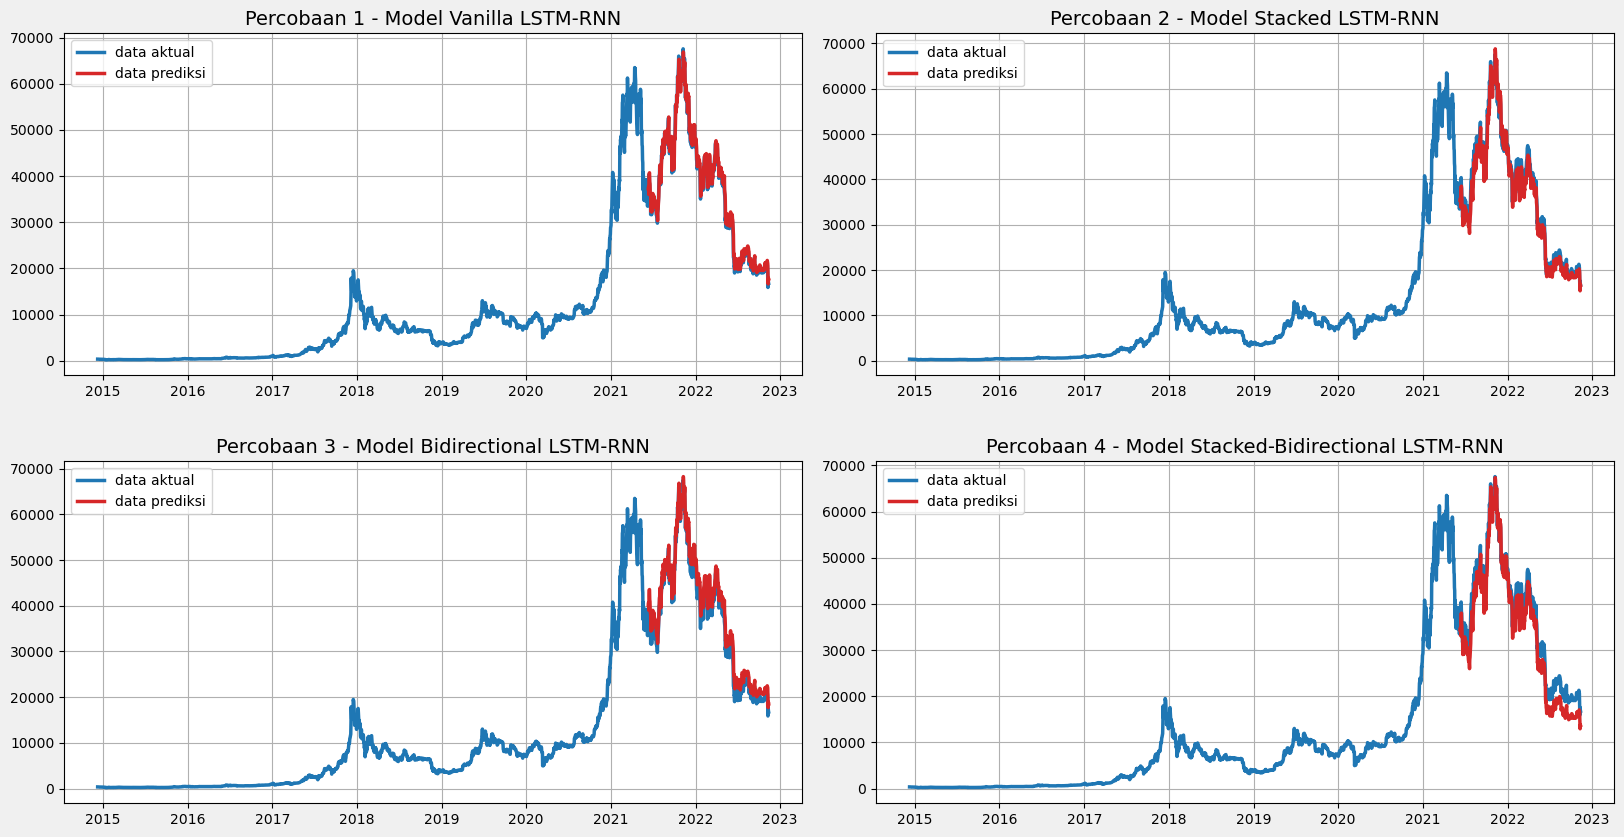

In [106]:
# membuat frame
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, facecolor="#f0f0f0", figsize=(20, 10))

# membuat time series plot
ax1.plot(dataset.index.values, scaler.inverse_transform(scaled_data), color="tab:blue", label="data aktual", linewidth=2.5)
ax1.plot(dataset.index.values, testPredictionsPlot_1, color="tab:red", label="data prediksi", linewidth=2.5)

# membuat label-label
ax1.set_title("Percobaan 1 - Model Vanilla LSTM-RNN", fontsize=14)
ax1.legend(loc="best")
ax1.grid(True)
# ----------------------------------------------------------------------------------------------------

# membuat time series plot
ax2.plot(dataset.index.values, scaler.inverse_transform(scaled_data), color="tab:blue", label="data aktual", linewidth=2.5)
ax2.plot(dataset.index.values, testPredictionsPlot_2, color="tab:red", label="data prediksi", linewidth=2.5)

# membuat label-label
ax2.set_title("Percobaan 2 - Model Stacked LSTM-RNN", fontsize=14)
ax2.legend(loc="best")
ax2.grid(True)
# ----------------------------------------------------------------------------------------------------

# membuat time series plot
ax3.plot(dataset.index.values, scaler.inverse_transform(scaled_data), color="tab:blue", label="data aktual", linewidth=2.5)
ax3.plot(dataset.index.values, testPredictionsPlot_3, color="tab:red", label="data prediksi", linewidth=2.5)

# membuat label-label
ax3.set_title("Percobaan 3 - Model Bidirectional LSTM-RNN", fontsize=14)
ax3.legend(loc="best")
ax3.grid(True)
# ----------------------------------------------------------------------------------------------------

# membuat time series plot
ax4.plot(dataset.index.values, scaler.inverse_transform(scaled_data), color="tab:blue", label="data aktual", linewidth=2.5)
ax4.plot(dataset.index.values, testPredictionsPlot_4, color="tab:red", label="data prediksi", linewidth=2.5)

# membuat label-label
ax4.set_title("Percobaan 4 - Model Stacked-Bidirectional LSTM-RNN", fontsize=14)
ax4.legend(loc="best")
ax4.grid(True)
# ----------------------------------------------------------------------------------------------------

# set the spacing between subplots
plt.subplots_adjust(wspace=0.1, hspace=0.25)

# menampilkan plot
plt.show()

## 8. Complexity time

In [107]:
# Set akhir waktu komputasi 
end = time.time()

In [108]:
# Proses menghitung waktu komputasi
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)

In [109]:
# Hasil waktu komputasi
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

00:17:00.72
